<a href="https://colab.research.google.com/github/Gilf641/EVA4/blob/master/S10_AssignmentFinalSolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Mount your G-Drive**

In [1]:
from __future__ import print_function
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


**Add Library Path in your def search path**

In [2]:
import sys
sys.path.append('/content/drive/My Drive/EVA4/updLib2/evaLibrary')
!ls '/content/drive/My Drive/EVA4/updLib2/evaLibrary'

AlbTestTransforms.py   all.py	       execute.py    __pycache__
AlbTrainTransforms.py  DataLoaders.py  Gradcam.py    resNet.py
albumentations.py      displayData.py  LR_Finder.py  rohan_library.py


In [0]:
# !pip install torch-lr-finder -v --global-option="amp"

**Import required libraries**

In [3]:
from rohan_library import *
import execute
from resNet import ResNet18
import displayData as display
import Gradcam as gc
import albumentations as alb
import DataLoaders as loader
import AlbTestTransforms
import AlbTrainTransforms
import LR_Finder as lrf

  pip install torch-lr-finder -v --global-option="amp"


REQUIRED LIBRARIES LOADED...


**Albumentations**

In [0]:
# from albumentations import Compose, Normalize
# from albumentations.pytorch import ToTensor
albTrain = AlbTrainTransforms.train_transforms()
albTest = AlbTestTransforms.test_transforms()

**Load the Datasets**

In [5]:
train = torchvision.datasets.CIFAR10(root = './data', train = True, download = True, transform = albTrain)
test = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform = albTest)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


**DataLoader for Train & Test Dataset**

In [0]:
dl = loader.DataLoaders()
trainLoader = dl.dataLoader(train)
testLoader = dl.dataLoader(test)


In [7]:
dataiter = iter(trainLoader)

images, labels = dataiter.next()
print(images.shape)
print(labels.shape)

torch.Size([128, 3, 32, 32])
torch.Size([128])


**Displaying Random Images**

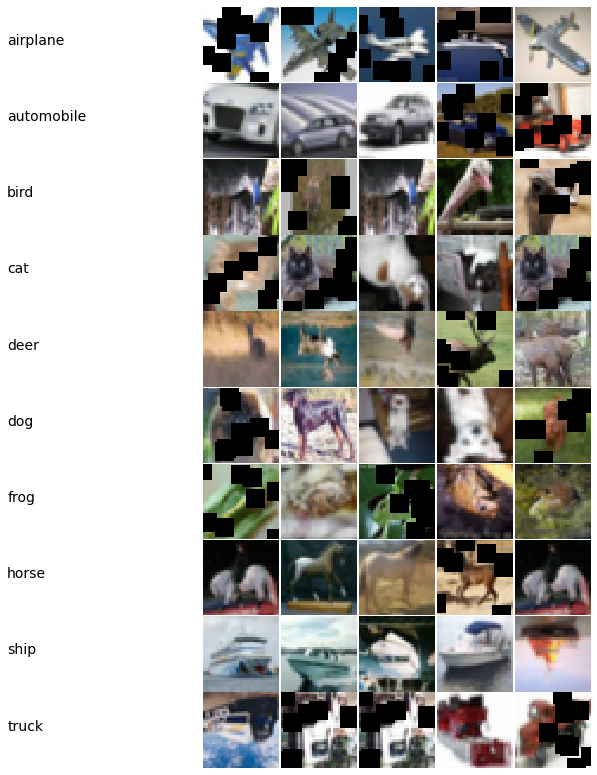

In [8]:
display.classImages(trainLoader)

**Model Summary**

In [9]:
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
print('Device set to ', device)

model = ResNet18().to(device)
summary(model, input_size=(3,32,32))

Device set to  cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-1

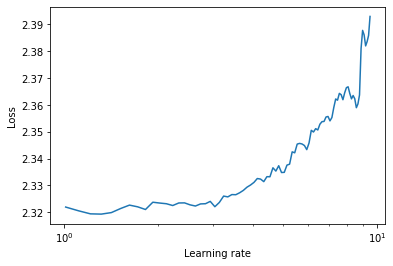

In [83]:
# #defining optimizer and scheduler
# optimizer = optim.SGD(model.parameters(), lr = 1e-4, momentum=0.9,  nesterov = True)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')#, patience=10, factor = 0.01)

# #creating model1 to import test and train modules
# model1 = execute.Test_Train(model,device,optimizer,scheduler)
# incorrect_samples = []
# criterion = execute.cross_entropy_loss()



# #Lr finder code
# lr_finder = lrf.LRFinder(model,  optimizer,  criterion, device="cuda")
# lr_finder.range_test(trainLoader,start_lr = 1e-3, end_lr=10, num_iter=100)
# lr_finder.plot() # to inspect the loss-learning rate graph
# lr_finder.reset() # to reset the model and optimizer to their initial state

In [10]:
criterion = execute.cross_entropy_loss()
optimizer = optim.SGD(model.parameters(), lr=1e-7, weight_decay=1e-2)
lr_finder = lrf.LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(trainLoader, end_lr=100, num_iter=100, step_mode="exp")

The loss has diverged, Stopping Early!


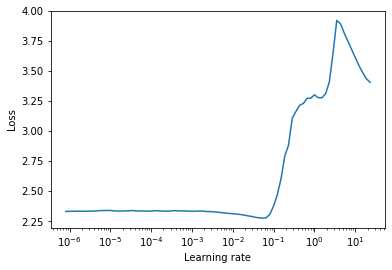

In [11]:
lr_finder.plot()

In [0]:
lr_finder.reset()

**LR Finder**

**FastAI Approach**

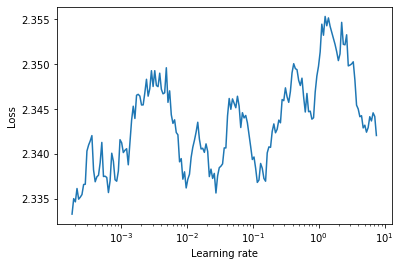

In [30]:
def fastaiApproach(model, optimizer, criterion, device ='cuda'):#, end_lr, num_iter): # fastai approach
  lrF = lrf.LRFinder(model, optimizer, criterion, device)
  lrF.range_test(trainLoader, end_lr=10, num_iter =200, step_mode='exp')
  lrF.plot()
  lrF.reset()

def lsApproach(model, optimizer, criterion, device ='cuda'): # leslie smith approach
  lrF = lrf.LRFinder(model, optimizer, criterion, device)
  lrF.range_test(trainLoader, testLoader, end_lr=10, num_iter =200, step_mode='exp')
  lrF.plot()
  lrF.reset()


fastaiApproach(model, optimizer, criterion, device)


**Modelling**

In [12]:
incorrectSamples = []
correctSamples = []
correctLabels = []
model = ResNet18().to(device)


criterion = execute.cross_entropy_loss()
optimizer = optim.SGD(model.parameters(), lr = 0.009, momentum=0.9, weight_decay=1e-4, nesterov = True) # change it to 0.01 or 0.009
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', patience=2, verbose=False)


model1 = execute.Test_Train(model, device, optimizer, criterion)
EPOCHS = 10


for epoch in range(1, EPOCHS+1):
  print('EPOCH: ',epoch)
  model1.train(trainLoader, epoch, L1lambda = 1e-5 )
  model1.test(testLoader, 'model1.pt', correctSamples, correctLabels, incorrectSamples)
  scheduler.step(model1.test_losses[-1])

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH:  1


Loss=2.5084471702575684 Batch_id=390 Accuracy=41.63: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Validation loss has  decreased (inf --> 1.3594).  Saving model ...

Test set: Average loss: 1.3594, Accuracy: 5356/10000 (53.56%)

EPOCH:  2


Loss=2.1400394439697266 Batch_id=390 Accuracy=55.64: 100%|██████████| 391/391 [03:13<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Validation loss has  decreased (1.3594 --> 0.5837).  Saving model ...

Test set: Average loss: 0.5837, Accuracy: 6213/10000 (62.13%)

EPOCH:  3


Loss=1.9559249877929688 Batch_id=390 Accuracy=62.33: 100%|██████████| 391/391 [03:13<00:00,  2.02it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7316, Accuracy: 6506/10000 (65.06%)

EPOCH:  4


Loss=1.8337658643722534 Batch_id=390 Accuracy=66.49: 100%|██████████| 391/391 [03:13<00:00,  2.02it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.3777, Accuracy: 6771/10000 (67.71%)

EPOCH:  5


Loss=1.8112752437591553 Batch_id=390 Accuracy=69.10: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.6683, Accuracy: 6793/10000 (67.93%)

EPOCH:  6


Loss=1.7496061325073242 Batch_id=390 Accuracy=75.43: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.8300, Accuracy: 7854/10000 (78.54%)

EPOCH:  7


Loss=1.6256134510040283 Batch_id=390 Accuracy=77.46: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Validation loss has  decreased (0.5837 --> 0.4260).  Saving model ...

Test set: Average loss: 0.4260, Accuracy: 7934/10000 (79.34%)

EPOCH:  8


Loss=1.4664353132247925 Batch_id=390 Accuracy=78.15: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.0243, Accuracy: 7937/10000 (79.37%)

EPOCH:  9


Loss=1.4506202936172485 Batch_id=390 Accuracy=78.52: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4891, Accuracy: 8042/10000 (80.42%)

EPOCH:  10


Loss=1.5232127904891968 Batch_id=390 Accuracy=79.27: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]



Test set: Average loss: 1.0082, Accuracy: 8061/10000 (80.61%)



**Plot Train & Test Curves**

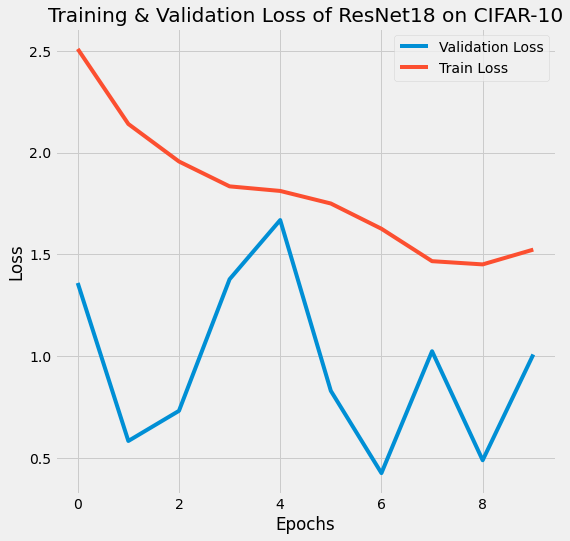

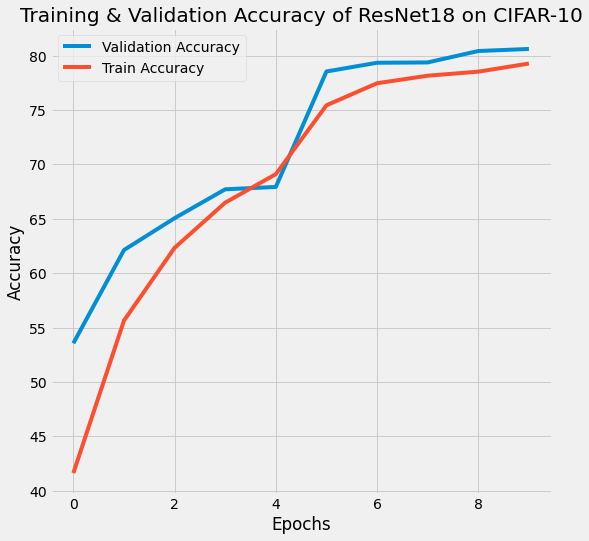

In [13]:
accuracyElements = [(model1.test_acc,"Validation Accuracy"),(model1.train_epoch_end,"Train Accuracy")]
lossElements = [(model1.test_losses,"Validation Loss"),(model1.train_losses,"Train Loss")]

for i in range(1):
  display.plot_curve(lossElements,'Training & Validation Loss of ResNet18 on CIFAR-10', y_label='Loss')
  display.plot_curve(accuracyElements,'Training & Validation Accuracy of ResNet18 on CIFAR-10')

**Data for GradCam**

**GradCam Implementation**

In [14]:

images = [x['image'] for x in incorrectSamples[10:20]]
target_classes = [l['label'] for l in incorrectSamples[10:20]]
predicted_classes = [p['prediction'] for p in incorrectSamples[10:20]]
# print(images)
print('***target-classes***')
tc = [classes[t] for t in target_classes]


print('***predicted-classes***')
pc = [classes[p] for p in predicted_classes]


***target-classes***
***predicted-classes***


torch.Size([10, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3
Generating Grad-CAM @layer4


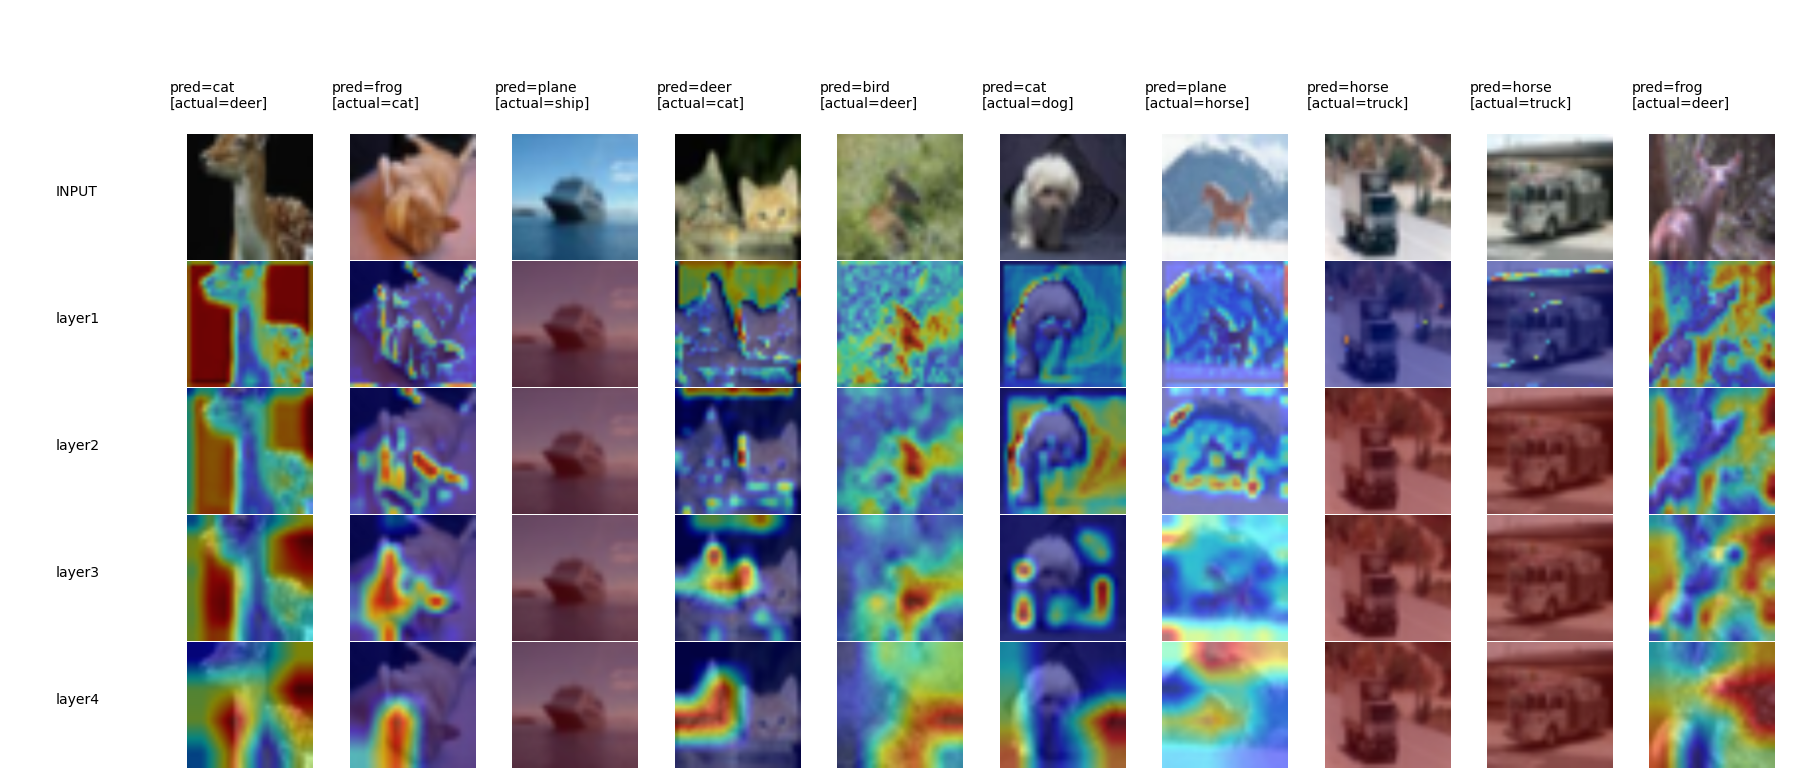

In [15]:

model = ResNet18().to(device)
image_size = (3,32,32)

target_layers = ["layer1", "layer2", "layer3", "layer4"]
gradcam_output, probs, predicted_classes = gc.GRADCAM(images, device, target_classes, model, target_layers) # target_classes required only in GRADCAM func

gc.PLOT(gradcam_output, images, target_layers, image_size, display.unnormalize, tc, pc)


<Figure size 936x936 with 0 Axes>

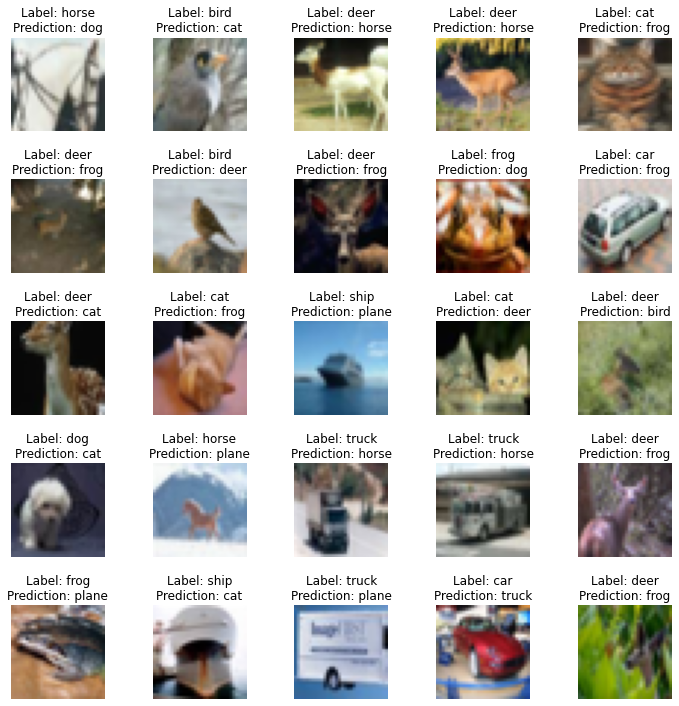

In [16]:
display.misclassifiedOnes(model, testLoader, incorrectSamples,'Misclassfied.png')